# Problem 1 - Lunar Lander environment

Implement a deep reinforcement learning agent for a game or environment of OpenAI Gym or Gymnasium.

Use the lunar_lander environment: https://gymnasium.farama.org/environments/box2d/lunar_lander/.

Please plot the learning progress of your method from 0 to 1000 episodes.

You can have a figure to show rewards and another figure to show training loss.

Please use a video or gifs or figures to demonstrate how your agent works.

## Goal

The goal is to control a spacecraft as it tries to land safely on the moon's surface while using as little fuel as possible and avoiding being tilted

## State Space (8, ) - Continuous

- x coordinates
- y coordinates
- horizontal speed
- vertical speed
- angle
- how fast it is spinning
- whether right landing legs are touching the ground
- whether left landing legs are touching the ground


## Action Space (4 choices) - Discrete

- 0: doing nothing
- 1: firing the left engine
- 2: firing the right engine
- 3: firing the main engine

## Reward Function

The agent receives feedback based on its performance at each timestep:

- The reward increases when the lander moves closer to the landing zone, and decreases if it moves farther away.

- The reward is increased when the lander is slowing down, and decreased when it moves too fast.

- A penalty is given if the lander is tilted, meaning it is not level with the ground.

- The agent earns 10 points for each leg that touches the ground.

- A small penalty of 0.03 points is given for every time a side engine is used.

- A larger penalty of 0.3 points is given for each time the main engine is fired.

At the end of the episode, the agent gets a bonus reward of +100 points for landing successfully, or a penalty of -100 points if it crashes.

The total reward of an episode is the sum of the rewards for all the steps within that episode.

An episode is considered successful if the agent scores at least 200 points.

## Loss Composition:
The total loss used in training the PPO algorithm is calculated as:

**totalLoss = PolicyLoss − 𝑐1 × ValueLoss + 𝑐2 × EntropyBonus**

This formula represents how the algorithm calculates the error during training and adjusts the policy network accordingly. The total loss is updated periodically over each Rollout cycle, which represents the data collection period. The total loss consists of the following components:

**Policy Loss**: This term measures how much the current policy (the agent’s decision-making strategy) differs from the expected or optimal policy. The lower the policy loss, the better the policy.

**Value Loss**: This term represents how much the agent's predicted value (the expected future reward from a given state) differs from the actual observed reward. It is related to the accuracy of the value function used to evaluate actions.

**Entropy Regularisation Reward (Entropy Bonus)**: This term encourages exploration by rewarding randomness in the agent’s actions. The idea is that the agent should not always stick to the same actions but should try different things to explore new strategies. A higher entropy bonus helps the agent explore more, while a lower one focuses the agent on exploiting its learned strategy.

Using cpu device
tarting training until 1000 episodes...
Mean Reward = 273.4567004, Std Reward = 15.83260823899422
GIF saved to 20250415150503_ppo_lunarlander.gif


/Users/mankakiu/Documents/Python_AI_Project/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/mankakiu/Documents/Python_AI_Project/Bioinspired_Optimisation/Assignment2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video saved to 20250415150503_ppo_lunarlander


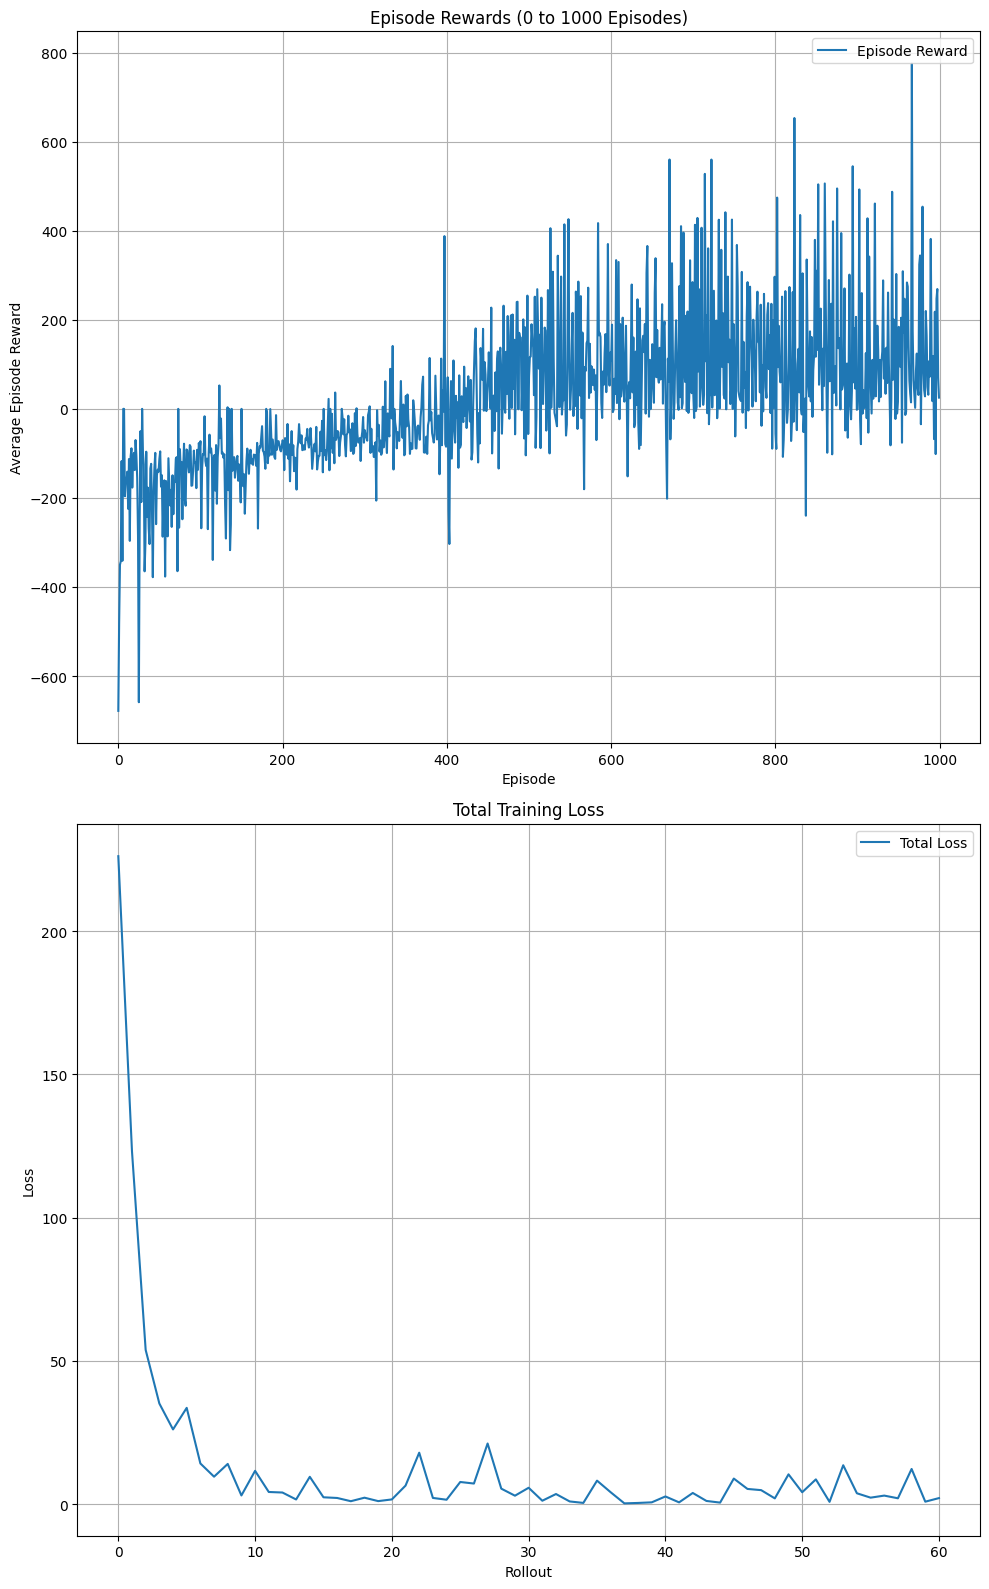

The training curve has been saved to 20250415150503_ppo_lunarlander_training_curves.png


In [2]:
# 1. Optuna runs 200 trials to find the best hyperparameters for the training process.
# 2. The PPO model is trained over 1000 episodes to figure out the best neural network weights (which control how the agent makes decisions), i.e., the correct sequence of actions the agent should take in different situations.

# 1 episode is 1 full experiment based on the selected parameters.
# A single model might need many steps to complete an episode, but since the environment changes each time, the number of steps required can differ between experiments.
# Rewards are calculated over each episode, so the x-axis on the reward graph shows the number of episodes.
# Loss is calculated over each step, so the x-axis on the loss graph represents the total number of steps taken across all 1000 episodes, divided by the n_steps parameter from the best hyperparameters.

import optuna   # Optuna is used for hyperparameter optimisation
import imageio  # Create GIF animations to visualise the agent's performance
import datetime
import matplotlib.pyplot as plt
from functools import partial
from typing import Optional
import gymnasium  # Provide the LunarLander-v3 environment for training
from gymnasium.wrappers import RecordVideo  # Record gameplay videos
from stable_baselines3 import PPO   # PPO algorithm
from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat # Log training data
from stable_baselines3.common.monitor import Monitor  # Monitor episode rewards and lengths
from stable_baselines3.common.vec_env import DummyVecEnv  # Vectorised environment for parallel training
from stable_baselines3.common.evaluation import evaluate_policy   # Evaluate the trained model's performance
from stable_baselines3.common.callbacks import BaseCallback

# Silently log training results to a file without printing to the console
class SilentLogger(Logger):
    def __init__(self, log_file: Optional[str] = None):
        output_formats = []
        if log_file:
            output_formats.append(CSVOutputFormat(log_file))  # Set up CSV logging to the specified file
        super().__init__(folder=None, output_formats=output_formats)
    def record(self, key: str, value, exclude: Optional[KVWriter] = None) -> None:
        super().record(key, value, exclude)
    def dump(self, step: int = 0) -> None:
        # Write logged data to the output file at the given step
        super().dump(step)

# Track rewards, losses, and control episode count during training
class TrainingCallback(BaseCallback):
    def __init__(self, total_episodes, verbose):
        super().__init__(verbose)
        self.total_episodes = total_episodes  # Total number of episodes to train
        self.episode_count = 0  # Counter for completed episodes
        self.episode_rewards = []  # List to store rewards for each episode
        self.current_episode_reward = 0 # Running total reward for current episode
        self.total_loss = [] # Store loss values after each rollout
        self.policy_loss,self.value_loss,self.entropy = [],[],[] # Lists to store individual components of the loss

    # Called at each step to update rewards and check episode completion
    def _on_step(self) -> bool:
        # Add the sum of rewards from all parallel environments to the current episode total
        self.current_episode_reward += sum(self.locals['rewards'])
        dones = self.locals.get('dones', [False] * self.model.env.num_envs) # Check which environments are done
        for done in dones:
            if done:  # If an episode has ended in any environment
                self.episode_count += 1 # Increment episode counter
                self.episode_rewards.append(self.current_episode_reward)  # Store the completed episode's total rewards
                self.current_episode_reward = 0 # Reset reward for next episode
                if self.verbose > 0:
                    print(f"Episode: {self.episode_count}/{self.total_episodes}", end="\r")
                if self.episode_count >= self.total_episodes:
                    return False  # Stop training when target episodes reached
        return True # Continue training

    # Called at the end of each rollout to record loss value
    def _on_rollout_end(self) -> None:
        if hasattr(self.model, 'logger'):
            # Retrieve and store the total training loss
            loss = self.model.logger.name_to_value.get('train/loss')
            if loss is not None: self.total_loss.append(loss) # Append loss to history

            # Invidual loss components
            # policy_loss = self.model.logger.name_to_value.get('train/policy_gradient_loss')
            # if policy_loss is not None: self.policy_loss.append(policy_loss)
            # value_loss = self.model.logger.name_to_value.get('train/value_loss')
            # if value_loss is not None: self.value_loss.append(value_loss)
            # entropy = self.model.logger.name_to_value.get('train/entropy')
            # if entropy is not None: self.entropy.append(loss)

# Optuna objective function for hyperparameter optimisation
# Train a model with sampled hyperparameters and returns average reward
def OptunaTrial(trial,model_type,parallel,total_timesteps,n_eval_episodes):
    # Define the hyperparameters search space (min, max, steps)
    hyperparams = {
        "learning_rate": trial.suggest_float("learning_rate", 0.00001, 0.01, log=True), # Control how quickly the model adjusts its behaviour based on feedback
        "n_steps": trial.suggest_int("n_steps", 256, 4096, step=256),               # How many steps the agent takes before updating its strategy and recording the results
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512]), # How many experiences the model will use at a time to update its strategy
        "gamma": trial.suggest_float("gamma", 0.9, 0.999, step=0.003),             # Control how much the agent values future rewards versus immediate rewards
        "gae_lambda": trial.suggest_float("gae_lambda", 0.8, 0.99, step=0.01),     # Control how much the agent considers just the immediate next step versus looking at the entire series of steps when evaluating its performance
        "clip_range": trial.suggest_float("clip_range", 0.1, 0.4, step = 0.05),       # Control how much the agent is allowed to change its strategy during each update
        "ent_coef": trial.suggest_float("ent_coef", 0.0001, 0.1, log=True),           # Control how much randomness the agent should have in its decisions
        "n_epochs": trial.suggest_int("n_epochs", 3, 20)                            # How many times the agent will review its experience and update its strategy during training
    }

    # Create a vectorised environment with 8 parallel instances of LunarLander-v3
    env = DummyVecEnv([lambda: Monitor(gymnasium.make(model_type)) for _ in range(parallel)])
    # Initialise PPO model with the sampled hyperparameters
    model = PPO("MlpPolicy", env, verbose=0, **hyperparams)
    try:
        # Train the model for 100,000 timesteps
        model.learn(total_timesteps=total_timesteps)
        # Evaluate the trained model over 10 episodes
        mean_reward, _ = evaluate_policy(model=model, env=env, n_eval_episodes=n_eval_episodes)
        # Report the mean reward to Optuna for optimisation
        trial.report(mean_reward, step=0)
        if trial.should_prune():  # If trial is underperforming, prune it
            raise optuna.exceptions.TrialPruned()
    finally:
        env.close() # Clean up by closing the environment
    return mean_reward  # Return the mean reward as the optimisation target

# Train the PPO agent with the best hyperparameters found by Optuna
def TrainPpoAgent(best_params, model_type, model_name, total_episodes, total_timesteps, parallel,n_eval_episodes):
    # Create a single environment and enable human rendering mode
    # setting up one instance of the environment and turning on the visual display so a human can watch what’s happening (like seeing the game play out on the screen).
    # env = Monitor(gym.make("LunarLander-v3", render_mode="human"))

    # Create a vectorised environment with specified number of parallel instances
    env = DummyVecEnv([lambda: Monitor(gymnasium.make(model_type)) for _ in range(parallel)])
    # Initialise PPO model with best hyperparameters
    model = PPO(policy = "MlpPolicy", env=env, verbose=1, **best_params)  # verbose=1 enables logging

    # Set up a silent logger to save training data to a CSV file
    logger = SilentLogger(log_file=f"{model_name}_training_log.csv")
    model.set_logger(logger)
    # Initialise callback to track training progress
    callback = TrainingCallback(total_episodes=total_episodes, verbose=1)
    print(f"tarting training until {total_episodes} episodes...")
    # Train the model, limiting to 10M timesteps, and use callback to monitor
    model.learn(total_timesteps=total_timesteps, callback=callback)
    model.save(model_name)  # Save the trained model
    # Evaluate the model over 10 episodes
    mean_reward, std_reward = evaluate_policy(model=model, env=env, n_eval_episodes=n_eval_episodes)
    print(f"Mean Reward = {mean_reward}, Std Reward = {std_reward}")
    env.close() # Clean up by closing the environment
    return model, callback  # Return the model and callback data

# Record a GIF of the agent's performance
def recordGif(id,model, filename, fps, duration, random_seed):
    # Create a monitored environment with RGB rendering
    with Monitor(gymnasium.make(id=id, render_mode="rgb_array")) as env:
        frames = [] # List to store rendered frames
        observation, _ = env.reset(seed = random_seed)  # Reset environment with seed
        for _ in range(fps * duration): # Run for specified duration
            frame = env.render()  # Render the current state
            if frame is None:
                raise ValueError("Environment render() returned None. Check render_mode.")
            frames.append(frame)  # Store the frame
            # Predict the next action deterministically
            action, _ = model.predict(observation=observation, deterministic=True)
            # Step the environment with the action
            observation, _, done, _, _ = env.step(action)
            if done:  # If episode ends, reset the environment
                observation, _ = env.reset()
        # Save frames as a GIF
        imageio.mimsave(uri=filename, ims=frames, fps=fps)
        print(f"GIF saved to {filename}")

# Record a video of the agent's performance
def recordVideo(id,model, video_name, random_seed):
    # Create an environment with video recording
    env = RecordVideo(
        Monitor(gymnasium.make(id= id, render_mode="rgb_array")),
        video_folder=".",
        name_prefix=video_name,
        episode_trigger=lambda x: True  # Record every episode
    )
    with env:
        observation, _ = env.reset(seed = random_seed)  # Reset environment with seed
        while True:
            # Predict the next action deterministically
            action, _ = model.predict(observation=observation, deterministic=True)
            # Step the environment and check for termination
            observation, _, done, truncated, _ = env.step(action)
            if done or truncated: # Stop if episode ends or is truncated
                break
    print(f"Video saved to {video_name}")

# Plot training curves for rewards and losses
def plotTrainingCurves(callback, model_name):
    plt.figure(figsize=(10, 16))
    # Plot episode rewards
    plt.subplot(2, 1, 1)
    plt.plot(callback.episode_rewards, label="Episode Reward")
    plt.title('Episode Rewards (0 to 1000 Episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Episode Reward')
    plt.legend()
    plt.grid(True)

    # Plot total loss. Assume each episode has about 300 steps on average
    # (LunarLander-v3 episodes typically range from 100 to 400 steps).
    # 8 - parallel environment, 1000 episodes
    # Rollout = 300 * 1000 / (8 * n_steps)
    plt.subplot(2, 1, 2)
    plt.plot(callback.total_loss, label="Total Loss")
    plt.title('Total Training Loss')
    plt.xlabel('Rollout')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_curves.png")
    plt.show()
    plt.close()
    print(f"The training curve has been saved to {model_name}_training_curves.png")

def main():
    model_type= "LunarLander-v3"
    # Use Optuna for hyperparameter tuning. It uses probability modeling to guess which combinations of parameters
    # are more likely to give better rewards, and then focuses on trying those combinations first

    # Default optimal parameters can be found at:
    # https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/ppo/ppo.html#PPO

    # # Example of best parameters found by Optuna:
    best_params = {
        'learning_rate': 0.001498919063649211,
        'n_steps': 1024,
        'batch_size': 256,
        'gamma': 0.993,
        'gae_lambda': 0.9600000000000001,
        'clip_range': 0.25,
        'ent_coef': 0.020190545985733898,
        'n_epochs': 19
    }

    # # Create an Optuna stude to maximise reward
    # study = optuna.create_study(direction="maximize")
    # # Run 200 trials to find the best hyperparameters
    # # study.optimize(OptunaTrial, n_trials=200)
    # study.optimize(partial(OptunaTrial,model_type=model_type,parallel=8,total_timesteps=100_000,n_eval_episodes=10), n_trials=200)
    #
    # # Print the best hyperparameters and results after optimisation
    # print("Best hyperparameters:", study.best_params
    #       , "\nBest accuracy:", study.best_value
    #       , "\nBest step:", study.best_params['n_steps'])

    base_name = f"{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}_ppo_lunarlander"

    # # Save Optuna trial results to a CSV file
    # trials_df = study.trials_dataframe()
    # completed_trials = trials_df[trials_df['state'] == 'COMPLETE']   # Filter completed trials
    # completed_trials.to_csv(f"{base_name}_optuna_log.csv", index=False)

    model_name = base_name
    # Train the PPO agent with the best parameters
    model, callback = TrainPpoAgent(best_params=best_params,model_type=model_type, model_name=model_name,total_episodes=1000,total_timesteps=10_000_000,parallel=8,n_eval_episodes=10)

    random_seed = 42  # Set a random seed to make sure the environment is the same each time when generating gifs and videos
    # Generate visualisation outputs (GIF, Video, Plots)
    recordGif(id=model_type, model=model, filename=f"{base_name}.gif", fps=30, duration=10, random_seed=random_seed)
    recordVideo(id=model_type, model=model, video_name=base_name,random_seed=random_seed)
    plotTrainingCurves(callback, model_name)

if __name__ == "__main__":
    main()